In [27]:
# END2END RESNET 
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import cv2
from PIL import Image


In [28]:
FRAME_INTERVAL = 5  # Capture every 5th frame
CLIP_LENGTH = 16  # Number of frames per clip for 3D CNN
FRAME_HEIGHT, FRAME_WIDTH = 224, 224  # r3d_18 with input 112x112 Slowfast 224x224

In [29]:
VIDEO_DIR = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur"
SAVE_DIR = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\Processed_Frames"
Anomaly_dir = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\anomaly_annotation.csv"

In [30]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalising the features
    ])

In [31]:
Anomaly_data = pd.read_csv(Anomaly_dir)
anomalies = set([anon.split("_")[0] for anon in Anomaly_data.name.values])
print(f'Anomalies: {anomalies}')

anno_names = Anomaly_data.name.values.tolist()
anno_start = Anomaly_data['starting frame of anomaly'].values.tolist()
anno_end = Anomaly_data['ending frame of anomaly'].values.tolist()

Anomalies: {'Traffic', 'Water', 'Object', 'Fire', 'People', 'Shooting', 'Vandalism', 'Fighting', 'Robbery', 'Explosion', 'Assault'}


In [32]:
# Save directory for extracted frames

def extract_and_save_frames(video_path, save_dir, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    save_folder = os.path.join(save_dir, video_name)
    os.makedirs(save_folder, exist_ok=True)

    frame_count = 0
    saved_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        if frame_count % frame_interval == 0:
            # Convert BGR (OpenCV) to RGB (PIL)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Apply transformations
            frame = transform(frame)  # Now it's a Tensor (C, H, W)

            # Convert back to PIL image to save
            frame = transforms.ToPILImage()(frame)

            # Save frame as JPEG
            frame_path = os.path.join(save_folder, f"frame_{saved_count:04d}.jpg")
            frame.save(frame_path, "JPEG")
            saved_count += 1 

        frame_count += 1
    
    cap.release()

In [8]:
# My iteration through
for root, _, files in os.walk(VIDEO_DIR):
    for video_file in tqdm(files, desc=f"Extracting Frames {root}"):
        if video_file.endswith((".mp4", ".avi", ".mov")):
            video_path = os.path.join(root, video_file)
            extract_and_save_frames(video_path, SAVE_DIR)

Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur: 0it [00:00, ?it/s]
Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur\MSAD_anomaly_blur: 0it [00:00, ?it/s]
Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur\MSAD_anomaly_blur\Ass
Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur\MSAD_anomaly_blur\Exp
Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur\MSAD_anomaly_blur\Fig
Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur\MSAD_anomaly_blur\Fir
Extracting Frames C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_blur\

In [33]:
anomaly = []
anonamly_bool = []
frame_paths = []
frames = []
video_names = []
video_path = []
import os
for root, _, files in os.walk(SAVE_DIR):
   for name in files:
      frame_path = os.path.join(root, name)
      components = frame_path.split(os.sep) 
      video_name =  components[-2]
      frame = int(components[-1].split("_")[1].split(".")[0]) * FRAME_INTERVAL
      frames.append(frame)
      video_names.append(video_name)
      #print(video_name) 
      frame_paths.append(frame_path)
      anom = video_name.split("_")[0]
      if anom in anomalies:
          #print(frame,video_name)
          pos = anno_names.index(video_name)
          start = anno_start[pos]
          end = anno_end[pos]

          if start < frame < end: 
              anon_bool = 1 
              anomaly_label = anom
          else:
              anon_bool = 0
              anomaly_label = "Normal"
         
      else:
          anon_bool = 0
          anomaly_label = "Normal"
      anomaly.append(anomaly_label)
      anonamly_bool.append(anon_bool)


metadata = pd.DataFrame({'Video':video_names,
              'Frame':frames,
             'Frames_path':frame_paths, 
             "Anomaly Type": anomaly,
             "Anomaly": anonamly_bool})

metadata["Video"] = metadata["Video"].str.replace("MSAD_normal_", "", regex=False)

In [34]:
with open(r'C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_I3D_WS_Train.list') as train:
    t = train.readlines()
    train_list = [item.split("\n")[0].split("/")[-1].replace("_i3d.npy","") for item in t]
    train_label = ["Train"] * len(train_list)
tr_labels = pd.DataFrame({"Video":train_list,
                        "partition":train_label}) 
with open(r'C:\Users\Keelan.Butler\Desktop\python_projects\Final Project\OneDrive_2025-01-30\MSAD Dataset\MSAD_I3D_WS_Test.list') as test:
    t = test.readlines()
    test_list = [item.split("\n")[0].split("/")[-1].replace("_i3d.npy","") for item in t]
    test_label = ["Test"] * len(test_list)

te_labels = pd.DataFrame({"Video":test_list,
                         "partition":test_label})
label_df = pd.concat([tr_labels,te_labels])
label_df["Video"] = label_df["Video"].str.replace("MSAD_normal_", "", regex=False)
label_df

,Video,partition
0,Assault_1,Train
1,Assault_3,Train
2,Assault_5,Train
3,Assault_6,Train
4,Assault_9,Train
...,...,...
235,testing_116,Test
236,testing_117,Test
237,testing_118,Test
238,testing_119,Test


In [35]:
df = pd.merge(left= metadata, right = label_df , on= "Video",how= "left")
df_train =  df[df["partition"] == "Train"].drop(columns= "partition")
df_test =  df[df["partition"] == "Test"].drop(columns= "partition")

In [36]:
class FrameDataset(Dataset):
    def __init__(self, labels_df, transform=None, clip_length=32, tau=4, step_size=8):
        """
        labels_df: DataFrame with columns ["Video", "Frame", "Frames_path", "Anomaly Type", "Anomaly"]
        transform: Image transformations (for resizing, normalizing, etc.)
        clip_length: Number of frames per sample for Fast Path (default 32)
        tau: Frame stride for Slow Path (default 4, meaning every 4th frame)
        step_size: How far the window moves per sample (default 8)
        """
        self.labels_df = labels_df.copy()  # Prevent modifying the original DataFrame
        self.transform = transform
        self.clip_length = clip_length
        self.tau = tau
        self.step_size = step_size

        # Ensure data is sorted by video and frame number
        self.labels_df.sort_values(by=["Video", "Frame"], inplace=True)

        # Group frames by video
        self.video_groups = self.labels_df.groupby("Video")

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels_df["Encoded_Label"] = self.label_encoder.fit_transform(self.labels_df["Anomaly"])

        # Store unique videos
        self.video_list = list(self.video_groups.groups.keys())

    def __len__(self):
        total_clips = 0
        for video_name in self.video_list:
            num_frames = len(self.video_groups.get_group(video_name))
            num_clips = max(0, (num_frames - self.clip_length) // self.step_size + 1)
            total_clips += num_clips
        return total_clips

    def __getitem__(self, idx):
        # Determine video & clip index
        total_clips = 0
        for video_name in self.video_list:
            video_frames = self.video_groups.get_group(video_name)
            num_frames = len(video_frames)
            num_clips = max(0, (num_frames - self.clip_length) // self.step_size + 1)

            if idx < total_clips + num_clips:
                clip_idx = idx - total_clips
                break

            total_clips += num_clips
        else:
            raise IndexError(f"Index {idx} is out of range for dataset of length {self.__len__()}")

        # Get frames & labels
        frame_paths = video_frames["Frames_path"].tolist()
        frame_labels = video_frames["Encoded_Label"].tolist()

        start_idx = clip_idx * self.step_size

        # Select frames for **Fast Path**
        fast_frames_paths = frame_paths[start_idx:start_idx + self.clip_length]
        fast_labels = frame_labels[start_idx:start_idx + self.clip_length]

        # Select frames for **Slow Path** (every `tau` frames from fast frames)
        slow_frames_paths = fast_frames_paths[::self.tau]
        slow_labels = fast_labels[::self.tau]

        # Ensure Slow Path has enough frames
        while len(slow_frames_paths) < self.clip_length // self.tau:
            slow_frames_paths.append(slow_frames_paths[-1])
            slow_labels.append(slow_labels[-1])

        # Load images
        def load_frames(paths):
            frames = []
            for frame_path in paths:
                frame = cv2.imread(frame_path)
                if frame is None:
                    raise ValueError(f"Error reading image: {frame_path}")

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                if self.transform:
                    frame = self.transform(frame)
                else:
                    frame = torch.from_numpy(frame).float()

                frames.append(frame)

            return torch.stack(frames)  # Shape: (T, C, H, W)

        fast_frames = load_frames(fast_frames_paths)
        slow_frames = load_frames(slow_frames_paths)

        # Transpose to match SlowFast input format (C, T, H, W)
        fast_frames = fast_frames.permute(1, 0, 2, 3)  # (C, T, H, W)
        slow_frames = slow_frames.permute(1, 0, 2, 3)  # (C, T/4, H, W)

        # Assign majority label
        clip_label = torch.tensor(fast_labels).mode()[0]  # Get most frequent label

        return [slow_frames, fast_frames], torch.tensor(clip_label, dtype=torch.long)


In [37]:
training_dataset = FrameDataset(labels_df = df_train)
testing_dataset = FrameDataset(labels_df = df_test)
print("Training dataset size: {}\ntesting dataset size: {}".format(len(training_dataset),len(testing_dataset)))
num_workers = min(6, os.cpu_count() - 1)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True, num_workers=0)##, pin_memory=True)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=16, shuffle=True, num_workers=0)#, pin_memory=True)

Training dataset size: 5598
testing dataset size: 2814


In [38]:
slowfast_model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

# Remove classification head
slowfast_model.blocks[-1] = nn.Identity() # Remove the final classification layer

class SlowFastBinaryClassifier(nn.Module):
    def __init__(self, slowfast_model):
        super(SlowFastBinaryClassifier, self).__init__()
        self.slowfast_model = slowfast_model
        self.fc = nn.Linear(2304 , 1)  # Output 1 for binary classification

    def forward(self, slow_frames, fast_frames):
        features = self.slowfast_model([slow_frames, fast_frames])  # Forward pass
        #print("Feature shape before pooling:", features.shape)
        
        features = F.adaptive_avg_pool3d(features, (1, 1, 1)).squeeze()

        return self.fc(features)

Using cache found in C:\Users\Keelan.Butler/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [39]:
model_binary = SlowFastBinaryClassifier(slowfast_model)

In [ ]:
# Training Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_binary = SlowFastBinaryClassifier(slowfast_model)

epochs = 25
losses = np.zeros((2, epochs))
model_binary.to(device)

optimiser = optim.Adam(model_binary.parameters(), lr=1e-4, weight_decay=1e-4)  
loss_function = nn.BCEWithLogitsLoss()

# Use GPU if available

print(f"Using device: {device}")


best_loss = np.inf

threshhold = 0.5 

# Training Loop
for epoch in range(epochs):
    epoch_loss = 0.0
    model_binary.train()

    for frames, labels in tqdm(training_dataloader, desc=f"Training pass epoch: {epoch}"):
        torch.cuda.empty_cache()  
        slow_frames, fast_frames = frames  # Unpack SlowFast inputs
        
        slow_frames, fast_frames, labels = (
            slow_frames.to(device),
            fast_frames.to(device),
            labels.to(device),
        )

        slow_frames = slow_frames.permute(0, 4, 2, 3, 1)
        fast_frames = fast_frames.permute(0, 4, 2, 3, 1)
        
        
        #print("slow_frames shape:", slow_frames.shape)
        #print("fast_frames shape:", fast_frames.shape)

        pred = model_binary(slow_frames, fast_frames)
        loss = loss_function(pred.squeeze(), labels.float())

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        epoch_loss += loss.item()
        torch.cuda.empty_cache()  
    # Store training loss
    losses[0, epoch] = epoch_loss / len(training_dataloader)

    # Validation Loop
    model_binary.eval()
    test_loss = 0.0

    with torch.no_grad():
        for test_frames, test_labels in tqdm(testing_dataloader, desc="Cycling Testing Dataloader"):
            slow_test_frames, fast_test_frames = test_frames  # Unpack test data
            
            slow_test_frames, fast_test_frames, test_labels = (
                slow_test_frames.to(device),
                fast_test_frames.to(device),
                test_labels.to(device),
            )
            slow_test_frames = slow_test_frames.permute(0, 4, 2, 3, 1)
            fast_test_frames = fast_test_frames.permute(0, 4, 2, 3, 1)

            test_preds = model_binary(slow_test_frames, fast_test_frames)  
            t_loss = loss_function(test_preds.squeeze(), test_labels.float())

            test_loss += t_loss.item()
            
    losses[1, epoch] = test_loss / len(testing_dataloader)

    # Save best model
    if best_loss > losses[1, epoch]:
        best_loss = losses[1, epoch] 
        print(f"Saving Optimal model: {epoch + 1} epoch")
        torch.save(model_binary.state_dict(), os.path.join("Best_Models", "E2E_SF.pt"))

    print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {losses[0,epoch]:.4f}, Test Loss: {losses[1,epoch]:.4f}")

Using device: cpu


Training pass:   0%|                                                                                                   | 0/350 [00:00<?, ?it/s]C:\Users\Keelan.Butler\AppData\Local\Temp\ipykernel_15332\541321580.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [slow_frames, fast_frames], torch.tensor(clip_label, dtype=torch.long)
Cycling Testing Dataloader: 100%|██████████████████████████████████████████████████████████████████████████| 176/176 [1:03:15<00:00, 21.56s/it]


Saving Optimal model: 1 epoch
Epoch [1/25] - Training Loss: 0.1616, Test Loss: 0.4057


Cycling Testing Dataloader: 100%|████████████████████████████████████████████████████████████████████████████| 176/176 [51:34<00:00, 17.58s/it]


Epoch [2/25] - Training Loss: 0.0513, Test Loss: 0.5424


Cycling Testing Dataloader: 100%|████████████████████████████████████████████████████████████████████████████| 176/176 [53:41<00:00, 18.31s/it]


Epoch [3/25] - Training Loss: 0.0325, Test Loss: 0.5527


Training pass:  38%|████████████████████████████████▏                                                   | 134/350 [5:12:22<8:21:02, 139.18s/it]

In [ ]:
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Testing')
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Slow-Fast Binary Classification Model")

In [20]:
model_binary.load_state_dict(torch.load(os.path.join("Best_Models", "E2E_SF.pt")))
print("Best model loaded!")

Best model loaded!


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_predictions(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for frames, labels in tqdm(dataloader):
            frames = frames
            labels = labels
            slow_frames, fast_frames = frames  # Unpack SlowFast inputs
        
            slow_frames, fast_frames, labels = (
                slow_frames.to(device),
                fast_frames.to(device),
                labels.to(device),
            )

            slow_frames = slow_frames.permute(0, 4, 2, 3, 1)
            fast_frames = fast_frames.permute(0, 4, 2, 3, 1)
            outputs = model(slow_frames, fast_frames)  # Forward pass
           # _, preds = torch.max(outputs, 1)  # Get predicted class MULTICLASS APPROACH
            #preds = (outputs >= 0.5).float() # Binalry class 
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    return np.array(all_labels), np.array(all_preds)

# Example usage:
device = torch.device(device)  # Change to "cuda" if using GPU
true_labels, pred_labels = get_predictions(model_binary, testing_dataloader, device)
print(f"Total test samples: {len(true_labels)} (Expected: 29270)")
print(f"Total predictions: {len(pred_labels)} (Expected: 29270)")


  0%|                                                                                                                  | 0/176 [00:00<?, ?it/s]C:\Users\Keelan.Butler\AppData\Local\Temp\ipykernel_15332\541321580.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [slow_frames, fast_frames], torch.tensor(clip_label, dtype=torch.long)
  1%|▌                                                                                                         | 1/176 [00:15<45:31, 15.61s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  1%|█▏                                                                                                        | 2/176 [00:32<46:54, 16.17s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  2%|█▊                                                                                                        | 3/176 [00:53<53:18, 18.49s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  2%|██▍                                                                                                       | 4/176 [01:11<52:19, 18.25s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  3%|███                                                                                                       | 5/176 [01:28<51:11, 17.96s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  3%|███▌                                                                                                      | 6/176 [01:46<50:36, 17.86s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  4%|████▏                                                                                                     | 7/176 [02:03<49:58, 17.74s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  5%|████▊                                                                                                     | 8/176 [02:26<54:02, 19.30s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  5%|█████▍                                                                                                    | 9/176 [02:47<55:13, 19.84s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  6%|█████▉                                                                                                   | 10/176 [03:06<53:50, 19.46s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  6%|██████▌                                                                                                  | 11/176 [03:24<52:08, 18.96s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  7%|███████▏                                                                                                 | 12/176 [03:42<51:14, 18.75s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  7%|███████▊                                                                                                 | 13/176 [04:00<50:10, 18.47s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  8%|████████▎                                                                                                | 14/176 [04:18<50:05, 18.55s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  9%|████████▉                                                                                                | 15/176 [04:38<50:53, 18.96s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


  9%|█████████▌                                                                                               | 16/176 [04:54<47:52, 17.95s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 10%|██████████▏                                                                                              | 17/176 [05:10<45:44, 17.26s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 10%|██████████▋                                                                                              | 18/176 [05:25<44:05, 16.74s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 11%|███████████▎                                                                                             | 19/176 [05:41<43:12, 16.52s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 11%|███████████▉                                                                                             | 20/176 [06:00<44:30, 17.12s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 12%|████████████▌                                                                                            | 21/176 [06:18<45:26, 17.59s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 12%|█████████████▏                                                                                           | 22/176 [06:35<44:51, 17.48s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 13%|█████████████▋                                                                                           | 23/176 [06:52<43:31, 17.07s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 14%|██████████████▎                                                                                          | 24/176 [07:08<42:29, 16.77s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 14%|██████████████▉                                                                                          | 25/176 [07:24<41:51, 16.63s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 15%|███████████████▌                                                                                         | 26/176 [07:44<44:15, 17.70s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 15%|████████████████                                                                                         | 27/176 [08:00<42:43, 17.20s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 16%|████████████████▋                                                                                        | 28/176 [08:17<42:02, 17.04s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 16%|█████████████████▎                                                                                       | 29/176 [08:33<40:51, 16.68s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 17%|█████████████████▉                                                                                       | 30/176 [08:48<39:52, 16.39s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 18%|██████████████████▍                                                                                      | 31/176 [09:04<39:04, 16.17s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 18%|███████████████████                                                                                      | 32/176 [09:23<40:53, 17.04s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 19%|███████████████████▋                                                                                     | 33/176 [09:40<40:20, 16.93s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 19%|████████████████████▎                                                                                    | 34/176 [09:58<40:47, 17.23s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 20%|████████████████████▉                                                                                    | 35/176 [10:14<39:28, 16.80s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 20%|█████████████████████▍                                                                                   | 36/176 [10:29<38:33, 16.52s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 21%|██████████████████████                                                                                   | 37/176 [10:45<37:50, 16.33s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 22%|██████████████████████▋                                                                                  | 38/176 [11:03<38:35, 16.78s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 22%|███████████████████████▎                                                                                 | 39/176 [11:20<38:42, 16.95s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 23%|███████████████████████▊                                                                                 | 40/176 [11:38<39:07, 17.26s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 23%|████████████████████████▍                                                                                | 41/176 [11:59<41:21, 18.38s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 24%|█████████████████████████                                                                                | 42/176 [12:20<42:38, 19.10s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 24%|█████████████████████████▋                                                                               | 43/176 [12:41<43:31, 19.63s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 25%|██████████████████████████▎                                                                              | 44/176 [13:05<45:52, 20.85s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 26%|██████████████████████████▊                                                                              | 45/176 [13:25<44:56, 20.58s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 26%|███████████████████████████▍                                                                             | 46/176 [13:45<44:05, 20.35s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 27%|████████████████████████████                                                                             | 47/176 [14:04<43:03, 20.03s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 27%|████████████████████████████▋                                                                            | 48/176 [14:23<42:29, 19.92s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 28%|█████████████████████████████▏                                                                           | 49/176 [14:43<42:01, 19.85s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 28%|█████████████████████████████▊                                                                           | 50/176 [15:03<41:47, 19.90s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 29%|██████████████████████████████▍                                                                          | 51/176 [15:22<40:49, 19.60s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 30%|███████████████████████████████                                                                          | 52/176 [15:41<40:02, 19.38s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 30%|███████████████████████████████▌                                                                         | 53/176 [15:59<39:04, 19.06s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 31%|████████████████████████████████▏                                                                        | 54/176 [16:18<38:20, 18.86s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 31%|████████████████████████████████▊                                                                        | 55/176 [16:36<37:40, 18.68s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 32%|█████████████████████████████████▍                                                                       | 56/176 [16:55<37:38, 18.82s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 32%|██████████████████████████████████                                                                       | 57/176 [17:14<37:25, 18.87s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 33%|██████████████████████████████████▌                                                                      | 58/176 [17:34<37:51, 19.25s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 34%|███████████████████████████████████▏                                                                     | 59/176 [17:56<38:52, 19.94s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 34%|███████████████████████████████████▊                                                                     | 60/176 [18:18<39:43, 20.55s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 35%|████████████████████████████████████▍                                                                    | 61/176 [18:38<39:18, 20.51s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 35%|████████████████████████████████████▉                                                                    | 62/176 [18:59<39:22, 20.73s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 36%|█████████████████████████████████████▌                                                                   | 63/176 [19:21<39:17, 20.86s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 36%|██████████████████████████████████████▏                                                                  | 64/176 [19:43<39:47, 21.31s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 37%|██████████████████████████████████████▊                                                                  | 65/176 [20:04<39:06, 21.14s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 38%|███████████████████████████████████████▍                                                                 | 66/176 [20:24<38:24, 20.95s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 38%|███████████████████████████████████████▉                                                                 | 67/176 [20:44<37:42, 20.75s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 39%|████████████████████████████████████████▌                                                                | 68/176 [21:07<38:04, 21.15s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 39%|█████████████████████████████████████████▏                                                               | 69/176 [21:28<37:44, 21.16s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 40%|█████████████████████████████████████████▊                                                               | 70/176 [21:50<38:08, 21.59s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 40%|██████████████████████████████████████████▎                                                              | 71/176 [22:12<37:46, 21.58s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 41%|██████████████████████████████████████████▉                                                              | 72/176 [22:35<38:24, 22.16s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 41%|███████████████████████████████████████████▌                                                             | 73/176 [22:59<38:42, 22.55s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 42%|████████████████████████████████████████████▏                                                            | 74/176 [23:25<40:17, 23.70s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 43%|████████████████████████████████████████████▋                                                            | 75/176 [23:50<40:29, 24.06s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 43%|█████████████████████████████████████████████▎                                                           | 76/176 [24:13<39:41, 23.81s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 44%|█████████████████████████████████████████████▉                                                           | 77/176 [24:36<38:37, 23.40s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 44%|██████████████████████████████████████████████▌                                                          | 78/176 [24:58<37:45, 23.12s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 45%|███████████████████████████████████████████████▏                                                         | 79/176 [25:19<36:06, 22.33s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 45%|███████████████████████████████████████████████▋                                                         | 80/176 [25:39<34:40, 21.67s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 46%|████████████████████████████████████████████████▎                                                        | 81/176 [25:59<33:40, 21.26s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 47%|████████████████████████████████████████████████▉                                                        | 82/176 [26:19<32:30, 20.75s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 47%|█████████████████████████████████████████████████▌                                                       | 83/176 [26:38<31:16, 20.17s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 48%|██████████████████████████████████████████████████                                                       | 84/176 [26:59<31:33, 20.59s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 48%|██████████████████████████████████████████████████▋                                                      | 85/176 [27:19<30:54, 20.38s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 49%|███████████████████████████████████████████████████▎                                                     | 86/176 [27:39<30:28, 20.32s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 49%|███████████████████████████████████████████████████▉                                                     | 87/176 [28:00<30:22, 20.48s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 50%|████████████████████████████████████████████████████▌                                                    | 88/176 [28:21<30:03, 20.49s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 51%|█████████████████████████████████████████████████████                                                    | 89/176 [28:40<29:24, 20.28s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 51%|█████████████████████████████████████████████████████▋                                                   | 90/176 [29:00<28:52, 20.15s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 52%|██████████████████████████████████████████████████████▎                                                  | 91/176 [29:24<30:10, 21.30s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 52%|██████████████████████████████████████████████████████▉                                                  | 92/176 [29:47<30:37, 21.88s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 53%|███████████████████████████████████████████████████████▍                                                 | 93/176 [30:11<30:46, 22.24s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 53%|████████████████████████████████████████████████████████                                                 | 94/176 [30:32<30:12, 22.10s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 54%|████████████████████████████████████████████████████████▋                                                | 95/176 [30:55<30:16, 22.43s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 55%|█████████████████████████████████████████████████████████▎                                               | 96/176 [31:17<29:41, 22.27s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 55%|█████████████████████████████████████████████████████████▊                                               | 97/176 [31:39<28:53, 21.95s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 56%|██████████████████████████████████████████████████████████▍                                              | 98/176 [32:00<28:27, 21.90s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 56%|███████████████████████████████████████████████████████████                                              | 99/176 [32:27<29:55, 23.32s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 57%|███████████████████████████████████████████████████████████                                             | 100/176 [32:53<30:23, 23.99s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 57%|███████████████████████████████████████████████████████████▋                                            | 101/176 [33:16<29:49, 23.86s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 58%|████████████████████████████████████████████████████████████▎                                           | 102/176 [33:39<29:07, 23.62s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 59%|████████████████████████████████████████████████████████████▊                                           | 103/176 [34:03<28:45, 23.64s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 59%|█████████████████████████████████████████████████████████████▍                                          | 104/176 [34:27<28:35, 23.83s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 60%|██████████████████████████████████████████████████████████████                                          | 105/176 [34:52<28:35, 24.16s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 60%|██████████████████████████████████████████████████████████████▋                                         | 106/176 [35:19<29:06, 24.96s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 61%|███████████████████████████████████████████████████████████████▏                                        | 107/176 [35:44<28:54, 25.13s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 61%|███████████████████████████████████████████████████████████████▊                                        | 108/176 [36:07<27:33, 24.31s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 62%|████████████████████████████████████████████████████████████████▍                                       | 109/176 [36:29<26:16, 23.53s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 62%|█████████████████████████████████████████████████████████████████                                       | 110/176 [36:51<25:24, 23.10s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 63%|█████████████████████████████████████████████████████████████████▌                                      | 111/176 [37:13<24:47, 22.89s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 64%|██████████████████████████████████████████████████████████████████▏                                     | 112/176 [37:36<24:19, 22.81s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 64%|██████████████████████████████████████████████████████████████████▊                                     | 113/176 [37:56<23:08, 22.04s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 65%|███████████████████████████████████████████████████████████████████▎                                    | 114/176 [38:17<22:21, 21.64s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 65%|███████████████████████████████████████████████████████████████████▉                                    | 115/176 [38:37<21:44, 21.38s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 66%|████████████████████████████████████████████████████████████████████▌                                   | 116/176 [38:58<21:13, 21.23s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 66%|█████████████████████████████████████████████████████████████████████▏                                  | 117/176 [39:20<21:04, 21.43s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 118/176 [39:46<22:02, 22.81s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 68%|██████████████████████████████████████████████████████████████████████▎                                 | 119/176 [40:11<22:16, 23.45s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 68%|██████████████████████████████████████████████████████████████████████▉                                 | 120/176 [40:34<21:48, 23.36s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 69%|███████████████████████████████████████████████████████████████████████▌                                | 121/176 [40:56<20:54, 22.81s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 69%|████████████████████████████████████████████████████████████████████████                                | 122/176 [41:18<20:17, 22.55s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 70%|████████████████████████████████████████████████████████████████████████▋                               | 123/176 [41:38<19:18, 21.86s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 70%|█████████████████████████████████████████████████████████████████████████▎                              | 124/176 [42:02<19:26, 22.43s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 71%|█████████████████████████████████████████████████████████████████████████▊                              | 125/176 [42:23<18:42, 22.00s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 72%|██████████████████████████████████████████████████████████████████████████▍                             | 126/176 [42:46<18:33, 22.28s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 72%|███████████████████████████████████████████████████████████████████████████                             | 127/176 [43:07<18:04, 22.13s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 73%|███████████████████████████████████████████████████████████████████████████▋                            | 128/176 [43:28<17:23, 21.73s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 73%|████████████████████████████████████████████████████████████████████████████▏                           | 129/176 [43:51<17:13, 21.99s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 74%|████████████████████████████████████████████████████████████████████████████▊                           | 130/176 [44:13<16:52, 22.01s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 74%|█████████████████████████████████████████████████████████████████████████████▍                          | 131/176 [44:37<17:04, 22.76s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 75%|██████████████████████████████████████████████████████████████████████████████                          | 132/176 [44:58<16:19, 22.26s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 76%|██████████████████████████████████████████████████████████████████████████████▌                         | 133/176 [45:19<15:29, 21.61s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 76%|███████████████████████████████████████████████████████████████████████████████▏                        | 134/176 [45:40<15:05, 21.57s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 77%|███████████████████████████████████████████████████████████████████████████████▊                        | 135/176 [46:02<14:45, 21.59s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 77%|████████████████████████████████████████████████████████████████████████████████▎                       | 136/176 [46:23<14:24, 21.61s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 137/176 [46:47<14:22, 22.12s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 138/176 [47:09<14:04, 22.23s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 139/176 [47:32<13:51, 22.48s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 80%|██████████████████████████████████████████████████████████████████████████████████▋                     | 140/176 [47:55<13:27, 22.44s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 80%|███████████████████████████████████████████████████████████████████████████████████▎                    | 141/176 [48:17<13:02, 22.35s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 81%|███████████████████████████████████████████████████████████████████████████████████▉                    | 142/176 [48:38<12:30, 22.08s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 81%|████████████████████████████████████████████████████████████████████████████████████▌                   | 143/176 [48:59<11:53, 21.63s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 82%|█████████████████████████████████████████████████████████████████████████████████████                   | 144/176 [49:21<11:40, 21.91s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                  | 145/176 [49:44<11:22, 22.02s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 146/176 [50:03<10:38, 21.29s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 84%|██████████████████████████████████████████████████████████████████████████████████████▊                 | 147/176 [50:24<10:10, 21.05s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 84%|███████████████████████████████████████████████████████████████████████████████████████▍                | 148/176 [50:46<09:58, 21.36s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 85%|████████████████████████████████████████████████████████████████████████████████████████                | 149/176 [51:05<09:18, 20.68s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 85%|████████████████████████████████████████████████████████████████████████████████████████▋               | 150/176 [51:23<08:35, 19.84s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 86%|█████████████████████████████████████████████████████████████████████████████████████████▏              | 151/176 [51:40<07:58, 19.14s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊              | 152/176 [51:58<07:29, 18.74s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 153/176 [52:16<07:07, 18.57s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 88%|███████████████████████████████████████████████████████████████████████████████████████████             | 154/176 [52:35<06:49, 18.60s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 155/176 [52:53<06:27, 18.47s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 89%|████████████████████████████████████████████████████████████████████████████████████████████▏           | 156/176 [53:11<06:09, 18.47s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 157/176 [53:30<05:49, 18.40s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 158/176 [53:47<05:27, 18.20s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▉          | 159/176 [54:06<05:10, 18.27s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▌         | 160/176 [54:25<04:54, 18.42s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏        | 161/176 [54:44<04:41, 18.75s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 162/176 [55:05<04:29, 19.25s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▎       | 163/176 [55:24<04:10, 19.23s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 164/176 [55:44<03:52, 19.40s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▌      | 165/176 [56:04<03:35, 19.61s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████      | 166/176 [56:23<03:16, 19.65s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▋     | 167/176 [56:43<02:57, 19.76s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎    | 168/176 [57:02<02:35, 19.48s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 169/176 [57:22<02:16, 19.49s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 170/176 [57:42<01:59, 19.85s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████   | 171/176 [58:01<01:37, 19.43s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 172/176 [58:19<01:15, 18.90s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 173/176 [58:36<00:55, 18.36s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 174/176 [58:53<00:36, 18.08s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍| 175/176 [59:10<00:17, 17.84s/it]

Feature shape before pooling: torch.Size([16, 2304, 1, 1, 1])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [59:25<00:00, 20.26s/it]

Feature shape before pooling: torch.Size([14, 2304, 1, 1, 1])
Total test samples: 2814 (Expected: 29270)
Total predictions: 2814 (Expected: 29270)


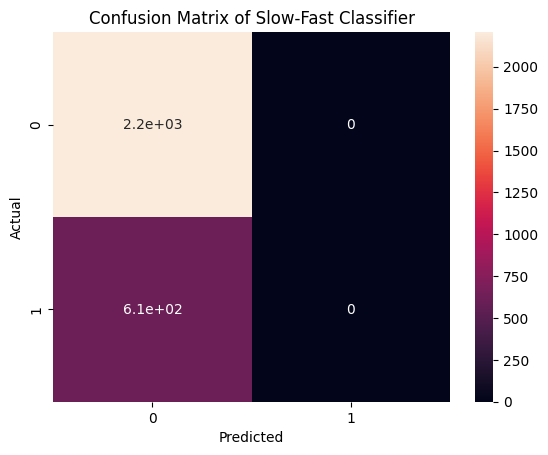

In [26]:
cm = metrics.confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm , annot = True)
plt.title("Confusion Matrix of Slow-Fast Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()